In [2]:
import numpy as np
np.random.seed(1337)  # for reproducibility

import cPickle as pkl
import gzip
import keras

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Merge, Input, Embedding, LSTM, Dense, merge, TimeDistributed, Lambda, average, multiply, Dot, dot
from keras.layers.core import *
from keras.layers.embeddings import Embedding
from keras.layers import Convolution1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.wrappers import Bidirectional
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
import keras.backend.tensorflow_backend as K
from keras.regularizers import l2
from keras.callbacks import *
from keras.models import *
from keras.optimizers import * 
from keras.activations import softmax

from IPython.display import SVG

import numpy as np
import cPickle as pkl
from nltk import FreqDist
import gzip


############################################# Preprocessing Starts ###############################################
def createMatrices(file, word2Idx, pos_tags_dict, maxSentenceLen=100):
    """Creates matrices for the events and sentence for the given file"""
    labels = []
    positionMatrix1 = []
    positionMatrix2 = []
    e1Matrix = []
    e2Matrix = []
    tokenMatrix = []
    pos_tags_Matrix = []
    count = 0
    
    line_no = 0 
    for line in open(file):
        line_no += 1
        splits = line.strip().split('\t')
        
        label = splits[0]
#         if "false" != label.lower():
#             label = "true"
        pos1 = splits[1]
        pos2 = splits[2]
        sentence = splits[3]
        tokens_postags = sentence.split(" ")
        
        tokens = []
        pos_tags = []
        
        for idx in range(len(tokens_postags)):
            if idx % 2 == 0:
                tokens.append(tokens_postags[idx])
            else:
                pos_tags.append(tokens_postags[idx])
                if tokens_postags[idx] not in pos_tags_dict:
                    pos_tags_dict[tokens_postags[idx]] = count
                    count += 1
        
        if len(tokens)!=len(pos_tags):
            print "false", line, line_no
        labelsDistribution[label] += 1
        
        tokenIds = np.zeros(maxSentenceLen)
        positionValues1 = np.zeros(maxSentenceLen)
        positionValues2 = np.zeros(maxSentenceLen)
        pos_tags_Ids = np.zeros(maxSentenceLen)
        e1 = 0
        e2 = 0
        
        for idx in xrange(0, min(maxSentenceLen, len(tokens))):
            tokenIds[idx] = getWordIdx(tokens[idx], word2Idx)
            pos_tags_Ids[idx] = pos_tags_dict[pos_tags[idx]]
            distance1 = idx - int(pos1)/2
            distance2 = idx - int(pos2)/2
            
            if distance1 == 0:
                e1 = tokenIds[idx]
            elif distance2 == 0:
                e2 = tokenIds[idx]
            
            if distance1 in distanceMapping:
                positionValues1[idx] = distanceMapping[distance1]
            elif distance1 <= minDistance:
                positionValues1[idx] = distanceMapping['LowerMin']
            else:
                positionValues1[idx] = distanceMapping['GreaterMax']
                
            if distance2 in distanceMapping:
                positionValues2[idx] = distanceMapping[distance2]
            elif distance2 <= minDistance:
                positionValues2[idx] = distanceMapping['LowerMin']
            else:
                positionValues2[idx] = distanceMapping['GreaterMax']
         
        pos_tags_Matrix.append(pos_tags_Ids)
        tokenMatrix.append(tokenIds)
        positionMatrix1.append(positionValues1)
        positionMatrix2.append(positionValues2)
        e1Matrix.append(e1)
        e2Matrix.append(e2)
        labels.append(labelsMapping[label])
        

    print pos_tags_dict
    return np.array(labels, dtype='int32'), np.array(tokenMatrix, dtype='int32'), np.array(pos_tags_Matrix, dtype='int32'), np.array(positionMatrix1, dtype='int32'), np.array(positionMatrix2, dtype='int32'), np.array(e1Matrix, dtype='int32'), np.array(e2Matrix, dtype='int32')


def getWordIdx(token, word2Idx): 
    """Returns from the word2Idex table the word index for a given token"""       
    if token in word2Idx:
        return word2Idx[token]
    elif token.lower() in word2Idx:
        return word2Idx[token.lower()]
    
    return word2Idx["UNKNOWN"]


outputFilePath = 'pkl/sem-relations.pkl.gz'
embeddingsPklPath = 'pkl/embeddings.pkl.gz'

embeddingsPath = 'wiki.en.vec'

folder = 'files/'
files = [folder + 'train_ddi_new.txt', folder + 'test_ddi_new.txt']

#Mapping of the labels to integers
'''
labelsMapping = {'false' : 0, 
                 'true' : 1}
'''
labelsMapping = {'false' : 0, 
                 'effect' : 1, 
                 'advise' : 2, 
                 'mechanism' : 3,
                 'int' : 4}

words = {}
pos_tags_dict = {}
maxSentenceLen = [0,0,0]
labelsDistribution = FreqDist()

distanceMapping = {'PADDING': 0, 'LowerMin': 1, 'GreaterMax': 2}
minDistance = -30
maxDistance = 30
for dis in xrange(minDistance,maxDistance+1):
    distanceMapping[dis] = len(distanceMapping)


for fileIdx in xrange(len(files)):
    file = files[fileIdx]
    print files[fileIdx]
    for line in open(file):
        splits = line.strip().split('\t')
        
        label = splits[0]
        
        
        sentence = splits[3]  
        tokens = sentence.split(" ")
        maxSentenceLen[fileIdx] = max(maxSentenceLen[fileIdx], len(tokens)/2)
        for token in tokens:
            words[token.lower()] = True
    print len(words)

print "Max Sentence Lengths: ", maxSentenceLen, len(words)
        
# :: Read in word embeddings ::
word2Idx = {}
embeddings = []
count = 0
for line in open(embeddingsPath):
    split = line.strip().split(" ")
    word = split[0]
    if len(word2Idx) == 0: #Add padding+unknown
        word2Idx["PADDING"] = len(word2Idx)
        vector = np.zeros(300)
        embeddings.append(vector)
        
        word2Idx["UNKNOWN"] = len(word2Idx)
        vector = np.random.uniform(-0.25, 0.25, 300)
        embeddings.append(vector)

    if word.lower() in words and word.lower() not in word2Idx:
        vector = np.array([float(num) for num in split[1:]])
        embeddings.append(vector)
        word2Idx[word.lower()] = len(word2Idx)
        count += 1
        
embeddings = np.array(embeddings)

print "Embeddings shape: ", embeddings.shape
print "Len words: ", len(words), count

f = gzip.open(embeddingsPklPath, 'wb')
pkl.dump(embeddings, f, -1)
f.close()

# :: Create token matrix ::
train_set = createMatrices(files[0], word2Idx, pos_tags_dict, max(maxSentenceLen))
print len(train_set)
test_set = createMatrices(files[1], word2Idx, pos_tags_dict, max(maxSentenceLen))
print len(test_set)

f = gzip.open(outputFilePath, 'wb')
pkl.dump(train_set, f, -1)
pkl.dump(test_set, f, -1)
f.close()

print "Data stored in pkl folder"

for label, freq in labelsDistribution.most_common(100):
    print "%s : %f%%" % (label, 100*freq / float(labelsDistribution.N()))
    
    
################################################## Preprocessing Ends ###################################################



################################################## Loading Data ########################################################

def getPrecision(pred_test, yTest, targetLabel):
    #Precision for non-vague
    targetLabelCount = 0
    correctTargetLabelCount = 0
    
    for idx in xrange(len(pred_test)):
        if pred_test[idx] == targetLabel:
            targetLabelCount += 1
            
            if pred_test[idx] == yTest[idx]:
                correctTargetLabelCount += 1
    
    if correctTargetLabelCount == 0:
        return 0
    
    return float(correctTargetLabelCount) / targetLabelCount


batch_size = 64
nb_filter = 100
filter_length = 3
hidden_dims = 100
nb_epoch = 50
position_dims = 50

print "Load dataset"
f = gzip.open('pkl/sem-relations.pkl.gz', 'rb')
yTrain, sentenceTrain, pos_tags_train, positionTrain1, positionTrain2, e1Train, e2Train = pkl.load(f)
yTest, sentenceTest, pos_tags_test, positionTest1, positionTest2, e1Test, e2Test  = pkl.load(f)
f.close()

max_position = max(np.max(positionTrain1), np.max(positionTrain2))+1

n_out = max(yTrain)+1
train_y_cat = np_utils.to_categorical(yTrain, n_out)


print "sentenceTrain: ", sentenceTrain.shape
print "positionTrain1: ", positionTrain1.shape
print "e1Train: ", e1Train.shape
print "e2Train: ", e2Train.shape
print "yTrain: ", yTrain.shape

print "sentenceTest: ", sentenceTest.shape
print "positionTest1: ", positionTest1.shape
print "e1Test: ", e1Test.shape
print "e2Test: ", e2Test.shape
print "yTest: ", yTest.shape


f = gzip.open('pkl/embeddings.pkl.gz', 'rb')
embeddings = pkl.load(f)
f.close()

print "Embeddings: ",embeddings.shape

########################################### Data Loading finished ######################################################


######################## MODEL with POS and trainable attention and Bidirectional LSTM
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        #ait = K.dot(uit, self.u)
        ait = dot_product(uit, self.u)
        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        #return K.sum(weighted_input, axis=1)
        print "here", weighted_input.shape
        return weighted_input
        
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2]
    

from keras.layers import Concatenate
#with POS and trainable attention and Bidirectional LSTM 0.6479, 
Input1 = Input(shape=(73,))
distanceModel1 = Embedding(max_position, position_dims, input_length=positionTrain1.shape[1])(Input1)

Input2 = Input(shape=(73,))
distanceModel2 = Embedding(max_position, position_dims, input_length=positionTrain2.shape[1])(Input2)

Input3 = Input(shape=(73,))
POSModel2 =Embedding(len(pos_tags_dict), position_dims, input_length=pos_tags_train.shape[1])(Input3)

Input4 = Input(shape=(73,))
wordModel = Embedding(embeddings.shape[0], embeddings.shape[1], 
                      input_length=sentenceTrain.shape[1], weights=[embeddings], trainable=False)(Input4)

print wordModel.shape
wordModel = Bidirectional(LSTM(150, return_sequences = True))(wordModel)
print wordModel.shape
wordModel = AttentionWithContext()(wordModel)
print wordModel.shape

c_models = Concatenate(axis = -1)([distanceModel1, distanceModel2, POSModel2, wordModel])
# c_models = Convolution1D(nb_filter=nb_filter,
#                         filter_length=filter_length,
#                         border_mode='same',
#                         activation='tanh',
#                         subsample_length=1)(c_models)

# c_models = GlobalMaxPooling1D()(c_models)
c_models = Bidirectional(LSTM(150))(c_models)
c_models = Dropout(0.25)(c_models)
c_models = Dense(n_out, activation='softmax')(c_models)

main_model = Model(inputs=[Input1, Input2, Input3, Input4], outputs=c_models)
main_model.compile(loss='categorical_crossentropy',optimizer='rmsprop')
main_model.summary()
SVG(model_to_dot(main_model, show_shapes="True", show_layer_names="False").create(prog='dot', format='svg'))

################################################## Model Complete ####################################################


################################################## Training begins ###################################################

print "Start training"
max_prec, max_rec, max_acc, max_f1 = 0,0,0,0
for epoch in xrange(50):
    print epoch
    main_model.fit([positionTrain1, positionTrain2, pos_tags_train, sentenceTrain], train_y_cat, batch_size=batch_size, verbose=True,nb_epoch=1)
    pred_vals = main_model.predict([ positionTest1, positionTest2, pos_tags_test, sentenceTest], verbose=False)
    pred_test = []
    for idx in range(len(pred_vals)):
        pred_test.append(np.argmax(pred_vals[idx]))

    pred_test=np.array(pred_test)
    dctLabels = np.sum(pred_test)
    totalDCTLabels = np.sum(yTest)
    
    acc =  np.sum(pred_test == yTest) / float(len(yTest))
    max_acc = max(max_acc, acc)
    print "Accuracy: %.4f (max: %.4f)" % (acc, max_acc)

    f1Sum = 0
    f1Count = 0
    for targetLabel in xrange(0, max(yTest)+1):
        prec = getPrecision(pred_test, yTest, targetLabel)
        rec = getPrecision(yTest, pred_test, targetLabel)
        f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
        #print f1
        f1Sum += f1
        f1Count +=1


    macroF1 = f1Sum / float(f1Count)
    max_f1 = max(max_f1, macroF1)
    print "Non-other Macro-Averaged F1: %.4f (max: %.4f)\n" % (macroF1, max_f1)

################################################## Training terminates ###################################################

#main_model.save("attention.model")

files/train_ddi_new.txt
5998
files/test_ddi_new.txt
6889
Max Sentence Lengths:  [73, 64, 0] 6889
Embeddings shape:  (1748, 300)
Len words:  6889 1746
{'vb': 10, 'cc': 7, 'topos': 9, 'jjs': 16, 'jjr': 18, 'cd': 15, 'prp': 20, 'nns': 8, 'nnp': 11, 'nnps': 29, 'wrb': 14, 'nn': 1, 'rb': 3, 'rbr': 27, 'fw': 23, 'pos': 28, 'jj': 6, 'wp': 26, 'rp': 24, 'dt': 0, 'md': 19, 'vbg': 4, 'vbd': 12, 'pdt': 30, 'rbs': 25, 'vbn': 13, 'inpos': 5, 'vbp': 2, 'wdt': 21, 'vbz': 17, 'ex': 22}
7
{'vb': 10, 'cc': 7, 'topos': 9, 'jjs': 16, 'jjr': 18, 'cd': 15, 'prp': 20, 'nns': 8, 'nnp': 11, 'nnps': 29, 'wrb': 14, 'nn': 1, 'rb': 3, 'rbr': 27, 'fw': 23, 'pos': 28, 'jj': 6, 'wp': 26, 'rp': 24, 'dt': 0, 'md': 19, 'vbg': 4, 'vbd': 12, 'pdt': 30, 'rbs': 25, 'vbn': 13, 'inpos': 5, 'vbp': 2, 'wdt': 21, 'vbz': 17, 'ex': 22}
7
Data stored in pkl folder
false : 69.650834%
effect : 12.261718%
mechanism : 9.820698%
advise : 6.505190%
int : 1.761560%
Load dataset
sentenceTrain:  (12840, 73)
positionTrain1:  (12840, 73)
e1Tr

/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:451: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
12840/12840 [==============================] - 82s - loss: 0.8391      

In [2]:
def createMatrices(file, word2Idx, pos_tags_dict, maxSentenceLen=100):
    """Creates matrices for the events and sentence for the given file"""
    labels = []
    positionMatrix1 = []
    positionMatrix2 = []
    e1Matrix = []
    e2Matrix = []
    tokenMatrix = []
    pos_tags_Matrix = []
    count = 0
    
    line_no = 0 
    for line in open(file):
        line_no += 1
        splits = line.strip().split('\t')
        
        label = splits[0]
        if "false" == label.lower():
            continue
        pos1 = splits[1]
        pos2 = splits[2]
        sentence = splits[3]
        tokens_postags = sentence.split(" ")
        
        tokens = []
        pos_tags = []
        
        for idx in range(len(tokens_postags)):
            if idx % 2 == 0:
                tokens.append(tokens_postags[idx])
            else:
                pos_tags.append(tokens_postags[idx])
                if tokens_postags[idx] not in pos_tags_dict:
                    pos_tags_dict[tokens_postags[idx]] = count
                    count += 1
        
        if len(tokens)!=len(pos_tags):
            print "false", line, line_no
        labelsDistribution[label] += 1
        
        tokenIds = np.zeros(maxSentenceLen)
        positionValues1 = np.zeros(maxSentenceLen)
        positionValues2 = np.zeros(maxSentenceLen)
        pos_tags_Ids = np.zeros(maxSentenceLen)
        e1 = 0
        e2 = 0
        
        for idx in xrange(0, min(maxSentenceLen, len(tokens))):
            tokenIds[idx] = getWordIdx(tokens[idx], word2Idx)
            pos_tags_Ids[idx] = pos_tags_dict[pos_tags[idx]]
            distance1 = idx - int(pos1)/2
            distance2 = idx - int(pos2)/2
            
            if distance1 == 0:
                e1 = tokenIds[idx]
            elif distance2 == 0:
                e2 = tokenIds[idx]
            
            if distance1 in distanceMapping:
                positionValues1[idx] = distanceMapping[distance1]
            elif distance1 <= minDistance:
                positionValues1[idx] = distanceMapping['LowerMin']
            else:
                positionValues1[idx] = distanceMapping['GreaterMax']
                
            if distance2 in distanceMapping:
                positionValues2[idx] = distanceMapping[distance2]
            elif distance2 <= minDistance:
                positionValues2[idx] = distanceMapping['LowerMin']
            else:
                positionValues2[idx] = distanceMapping['GreaterMax']
         
        pos_tags_Matrix.append(pos_tags_Ids)
        tokenMatrix.append(tokenIds)
        positionMatrix1.append(positionValues1)
        positionMatrix2.append(positionValues2)
        e1Matrix.append(e1)
        e2Matrix.append(e2)
        labels.append(labelsMapping[label])
        

    print pos_tags_dict
    return np.array(labels, dtype='int32'), np.array(tokenMatrix, dtype='int32'), np.array(pos_tags_Matrix, dtype='int32'), np.array(positionMatrix1, dtype='int32'), np.array(positionMatrix2, dtype='int32'), np.array(e1Matrix, dtype='int32'), np.array(e2Matrix, dtype='int32')


def getWordIdx(token, word2Idx): 
    """Returns from the word2Idex table the word index for a given token"""       
    if token in word2Idx:
        return word2Idx[token]
    elif token.lower() in word2Idx:
        return word2Idx[token.lower()]
    
    return word2Idx["UNKNOWN"]


outputFilePath = 'pkl/sem-relations.pkl.gz'
embeddingsPklPath = 'pkl/embeddings.pkl.gz'

embeddingsPath = 'wiki.en.vec'

folder = 'files/'
files = [folder + 'train_ddi_new.txt', folder + 'test_ddi_new.txt']

#Mapping of the labels to integers
'''
labelsMapping = {'false' : 0, 
                 'effect' : 1, 
                 'advise' : 2, 
                 'mechanism' : 3,
                 'int' : 4}
'''
labelsMapping = {'effect' : 0, 
                 'advise' : 1, 
                 'mechanism' : 2,
                 'int' : 3}

words = {}
pos_tags_dict = {}
maxSentenceLen = [0,0,0]
labelsDistribution = FreqDist()

distanceMapping = {'PADDING': 0, 'LowerMin': 1, 'GreaterMax': 2}
minDistance = -30
maxDistance = 30
for dis in xrange(minDistance,maxDistance+1):
    distanceMapping[dis] = len(distanceMapping)


for fileIdx in xrange(len(files)):
    file = files[fileIdx]
    print files[fileIdx]
    for line in open(file):
        splits = line.strip().split('\t')
        
        label = splits[0]
        
        
        sentence = splits[3]  
        tokens = sentence.split(" ")
        maxSentenceLen[fileIdx] = max(maxSentenceLen[fileIdx], len(tokens)/2)
        for token in tokens:
            words[token.lower()] = True
    print len(words)

print "Max Sentence Lengths: ", maxSentenceLen, len(words)
        
# :: Read in word embeddings ::
word2Idx = {}
embeddings = []
count = 0
for line in open(embeddingsPath):
    split = line.strip().split(" ")
    word = split[0]
    if len(word2Idx) == 0: #Add padding+unknown
        word2Idx["PADDING"] = len(word2Idx)
        vector = np.zeros(300)
        embeddings.append(vector)
        
        word2Idx["UNKNOWN"] = len(word2Idx)
        vector = np.random.uniform(-0.25, 0.25, 300)
        embeddings.append(vector)

    if word.lower() in words and word.lower() not in word2Idx:
        vector = np.array([float(num) for num in split[1:]])
        embeddings.append(vector)
        word2Idx[word.lower()] = len(word2Idx)
        count += 1
        
embeddings = np.array(embeddings)

print "Embeddings shape: ", embeddings.shape
print "Len words: ", len(words), count

f = gzip.open(embeddingsPklPath, 'wb')
pkl.dump(embeddings, f, -1)
f.close()

# :: Create token matrix ::
train_set = createMatrices(files[0], word2Idx, pos_tags_dict, max(maxSentenceLen))
print len(train_set)
test_set = createMatrices(files[1], word2Idx, pos_tags_dict, max(maxSentenceLen))
print len(test_set)

f = gzip.open(outputFilePath, 'wb')
pkl.dump(train_set, f, -1)
pkl.dump(test_set, f, -1)
f.close()

print "Data stored in pkl folder"

for label, freq in labelsDistribution.most_common(100):
    print "%s : %f%%" % (label, 100*freq / float(labelsDistribution.N()))
    
    
################################################## Preprocessing Ends ###################################################



################################################## Loading Data ########################################################

def getPrecision(pred_test, yTest, targetLabel):
    #Precision for non-vague
    targetLabelCount = 0
    correctTargetLabelCount = 0
    
    for idx in xrange(len(pred_test)):
        if pred_test[idx] == targetLabel:
            targetLabelCount += 1
            
            if pred_test[idx] == yTest[idx]:
                correctTargetLabelCount += 1
    
    if correctTargetLabelCount == 0:
        return 0
    
    return float(correctTargetLabelCount) / targetLabelCount


batch_size = 64
nb_filter = 100
filter_length = 3
hidden_dims = 100
nb_epoch = 50
position_dims = 50

print "Load dataset"
f = gzip.open('pkl/sem-relations.pkl.gz', 'rb')
yTrain, sentenceTrain, pos_tags_train, positionTrain1, positionTrain2, e1Train, e2Train = pkl.load(f)
yTest_2, sentenceTest_2, pos_tags_test_2, positionTest1_2, positionTest2_2, e1Test_2, e2Test_2  = pkl.load(f)
f.close()

max_position = max(np.max(positionTrain1), np.max(positionTrain2))+1

n_out = max(yTrain)+1
train_y_cat = np_utils.to_categorical(yTrain, n_out)


print "sentenceTrain: ", sentenceTrain.shape
print "positionTrain1: ", positionTrain1.shape
print "e1Train: ", e1Train.shape
print "e2Train: ", e2Train.shape
print "yTrain: ", yTrain.shape

print "sentenceTest: ", sentenceTest.shape
print "positionTest1: ", positionTest1.shape
print "e1Test: ", e1Test.shape
print "e2Test: ", e2Test.shape
print "yTest: ", yTest.shape


f = gzip.open('pkl/embeddings.pkl.gz', 'rb')
embeddings = pkl.load(f)
f.close()

print "Embeddings: ",embeddings.shape

files/train_ddi_new.txt
5998
files/test_ddi_new.txt
6889
Max Sentence Lengths:  [73, 64, 0] 6889
Embeddings shape:  (1748, 300)
Len words:  6889 1746
{'vb': 16, 'cc': 8, 'topos': 15, 'jjs': 7, 'jjr': 22, 'cd': 5, 'prp': 20, 'nns': 2, 'nnp': 11, 'nnps': 27, 'wrb': 10, 'nn': 4, 'rb': 12, 'rbr': 24, 'fw': 19, 'pos': 26, 'jj': 1, 'wp': 25, 'rp': 30, 'dt': 0, 'md': 17, 'vbg': 18, 'vbd': 6, 'pdt': 28, 'rbs': 29, 'vbn': 9, 'inpos': 3, 'vbp': 14, 'wdt': 21, 'vbz': 13, 'ex': 23}
7
{'vb': 16, 'cc': 8, 'topos': 15, 'jjs': 7, 'jjr': 22, 'cd': 5, 'prp': 20, 'nns': 2, 'nnp': 11, 'nnps': 27, 'wrb': 10, 'nn': 4, 'rb': 12, 'rbr': 24, 'fw': 19, 'pos': 26, 'jj': 1, 'wp': 25, 'rp': 30, 'dt': 0, 'md': 17, 'vbg': 18, 'vbd': 6, 'pdt': 28, 'rbs': 29, 'vbn': 9, 'inpos': 3, 'vbp': 14, 'wdt': 21, 'vbz': 13, 'ex': 23}
7
Data stored in pkl folder
effect : 40.402156%
mechanism : 32.359038%
advise : 21.434494%
int : 5.804312%
Load dataset
sentenceTrain:  (3853, 73)
positionTrain1:  (3853, 73)
e1Train:  (3853,)
e2Tra

(?, 73, 300)
(?, ?, 300)
here (?, 73, 300)
(?, 73, 300)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 73)            0                                            
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 73, 300)       524400      input_8[0][0]                    
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 73)            0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 73)            0                                            
___________________________________

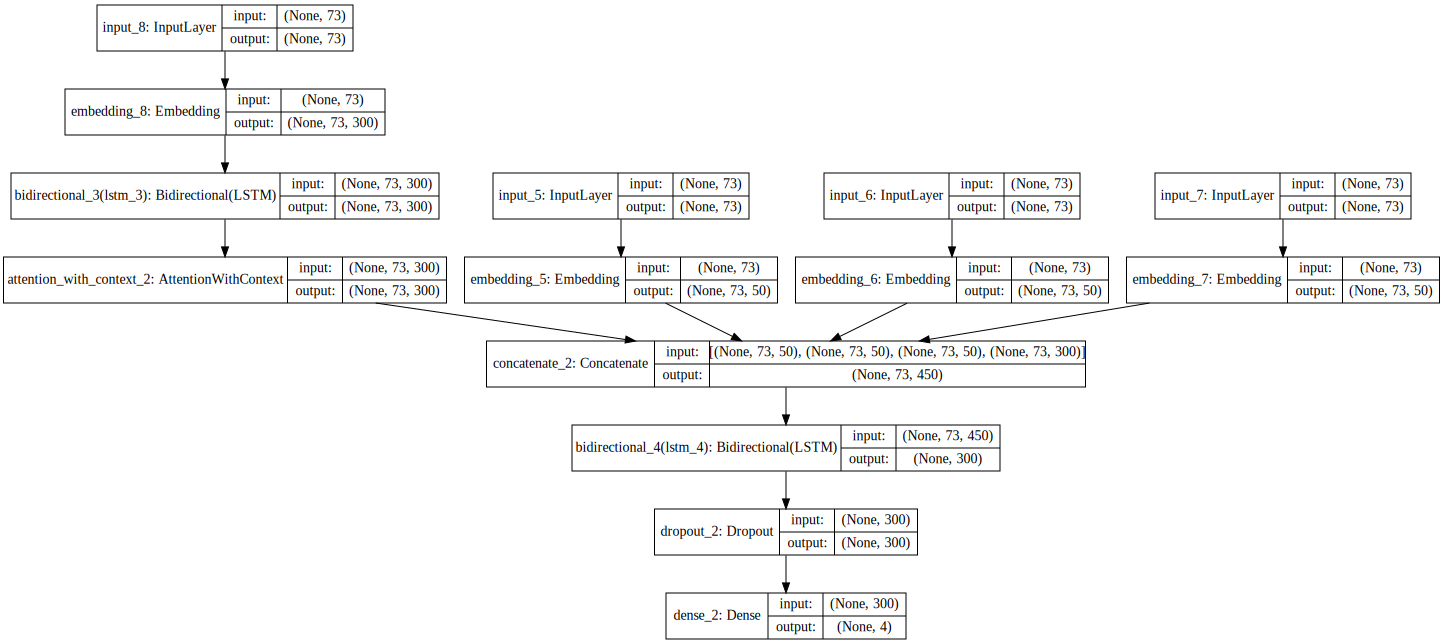

In [3]:
from keras.layers import Concatenate
#with POS and trainable attention and Bidirectional LSTM 0.6479, 
Input1 = Input(shape=(73,))
distanceModel1 = Embedding(max_position, position_dims, input_length=positionTrain1.shape[1])(Input1)

Input2 = Input(shape=(73,))
distanceModel2 = Embedding(max_position, position_dims, input_length=positionTrain2.shape[1])(Input2)

Input3 = Input(shape=(73,))
POSModel2 =Embedding(len(pos_tags_dict), position_dims, input_length=pos_tags_train.shape[1])(Input3)

Input4 = Input(shape=(73,))
wordModel = Embedding(embeddings.shape[0], embeddings.shape[1], 
                      input_length=sentenceTrain.shape[1], weights=[embeddings], trainable=False)(Input4)

print wordModel.shape
wordModel = Bidirectional(LSTM(150, return_sequences = True))(wordModel)
print wordModel.shape
wordModel = AttentionWithContext()(wordModel)
print wordModel.shape

c_models = Concatenate(axis = -1)([distanceModel1, distanceModel2, POSModel2, wordModel])
# c_models = Convolution1D(nb_filter=nb_filter,
#                         filter_length=filter_length,
#                         border_mode='same',
#                         activation='tanh',
#                         subsample_length=1)(c_models)

# c_models = GlobalMaxPooling1D()(c_models)
c_models = Bidirectional(LSTM(150))(c_models)
c_models = Dropout(0.25)(c_models)
c_models = Dense(n_out, activation='softmax')(c_models)

main_model2 = Model(inputs=[Input1, Input2, Input3, Input4], outputs=c_models)
main_model2.compile(loss='categorical_crossentropy',optimizer='rmsprop')
main_model2.summary()
SVG(model_to_dot(main_model2, show_shapes="True", show_layer_names="False").create(prog='dot', format='svg'))

In [4]:
print "Start training"
max_prec, max_rec, max_acc, max_f1 = 0,0,0,0
for epoch in xrange(10):
    print epoch
    main_model2.fit([positionTrain1, positionTrain2, pos_tags_train, sentenceTrain], train_y_cat, batch_size=batch_size, verbose=True,nb_epoch=1)
    pred_vals_2 = main_model2.predict([ positionTest1_2, positionTest2_2, pos_tags_test_2, sentenceTest_2], verbose=False)
#     pred_vals = main_model.predict([ np.array(positionTest1Stage2), np.array(positionTest2Stage2), np.array(pos_tags_testStage2), np.array(sentenceTestStage2), np.array(e1TestStage2), np.array(e2TestStage2)], verbose=False)
    pred_test_2 = []
    for idx in range(len(pred_vals_2)):
        pred_test_2.append(np.argmax(pred_vals_2[idx]))

    pred_test_2=np.array(pred_test_2)
    dctLabels = np.sum(pred_test_2)
    totalDCTLabels = np.sum(yTest_2)
#     newYTest = np.array(newYTest)
#     totalDCTLabels = np.sum(newYTest)

    acc =  np.sum(pred_test_2 == yTest_2) / float(len(yTest_2))
#     acc =  np.sum(pred_test == newYTest) / float(len(newYTest))
    max_acc = max(max_acc, acc)
    print "Accuracy: %.4f (max: %.4f)" % (acc, max_acc)

    f1Sum = 0
    f1Count = 0
    for targetLabel in xrange(0, max(yTest_2)+1):
        prec = getPrecision(pred_test_2, yTest_2, targetLabel)
        rec = getPrecision(yTest_2, pred_test_2, targetLabel)
#     for targetLabel in xrange(0, max(newYTest)+1):
#         prec = getPrecision(pred_test, newYTest, targetLabel)
#         rec = getPrecision(newYTest, pred_test, targetLabel)
        f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
        #print f1
        f1Sum += f1
        f1Count +=1


    macroF1 = f1Sum / float(f1Count)
    max_f1 = max(max_f1, macroF1)
    print "Non-other Macro-Averaged F1: %.4f (max: %.4f)\n" % (macroF1, max_f1)

Start training
0


/users/PAS1315/osu9128/envs/vqa2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/1
3853/3853 [==============================] - 26s - loss: 0.9608      

In [5]:
labelsMapping = {'false' : 0, 
                 'effect' : 1, 
                 'advise' : 2, 
                 'mechanism' : 3,
                 'int' : 4}

In [6]:
def getTrueLabels(file):
    true_labels = []
    for line in open(file):
        splits = line.strip().split('\t')
        label = splits[0]
        true_labels.append(labelsMapping[label])
        
    return true_labels

In [8]:
t_label_test = getTrueLabels(files[1])
newYTest = []
indices = []
positionTest1Stage2, positionTest2Stage2, pos_tags_testStage2, sentenceTestStage2, e1TestStage2, e2TestStage2 = [], [], [], [], [], []

pred_vals = main_model.predict([ positionTest1, positionTest2, pos_tags_test, sentenceTest], verbose=False)
pred_test = []
for idx in range(len(pred_vals)):
    pred_test.append(np.argmax(pred_vals[idx]))

pred_test=np.array(pred_test)
dctLabels = np.sum(pred_test)
totalDCTLabels = np.sum(yTest)
# newYTest = np.array(newYTest)
# totalDCTLabels = np.sum(newYTest)

for cnt in range(0, len(yTest)):
    if pred_test[cnt] == 1:
        indices.append(cnt)
        newYTest.append(t_label_test[cnt])
        positionTest1Stage2.append(positionTest1[cnt])
        positionTest2Stage2.append(positionTest2[cnt])
        pos_tags_testStage2.append(pos_tags_test[cnt])
        sentenceTestStage2.append(sentenceTest[cnt])
        e1TestStage2.append(e1Test[cnt])
        e2TestStage2.append(e2Test[cnt])

acc = 0 
max_acc = 0
acc =  np.sum(pred_test == yTest) / float(len(yTest))
max_acc = max(max_acc, acc)
print "Accuracy: %.4f (max: %.4f)" % (acc, max_acc)

f1Sum = 0
f1Count = 0
for targetLabel in xrange(0, max(yTest)+1):
    prec = getPrecision(pred_test, yTest, targetLabel)
    rec = getPrecision(yTest, pred_test, targetLabel)
    f1 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
    #print f1
    f1Sum += f1
    f1Count +=1

max_f1 = 0
macroF1 = 0
macroF1 = f1Sum / float(f1Count)
max_f1 = max(max_f1, macroF1)
print "Non-other Macro-Averaged F1: %.4f (max: %.4f)\n" % (macroF1, max_f1)

Accuracy: 0.7771 (max: 0.7771)
Non-other Macro-Averaged F1: 0.7480 (max: 0.7480)



In [9]:
print len(t_label_test)
print len(pred_test)

3055
3055


In [11]:
newYTest = np.array(newYTest)
pred_vals2 = main_model2.predict([ np.array(positionTest1Stage2), np.array(positionTest2Stage2), np.array(pos_tags_testStage2), np.array(sentenceTestStage2)], verbose=False)
pred_test2 = []
for idx in range(len(pred_vals2)):
    pred_test2.append(np.argmax(pred_vals2[idx]))

pred_test2=np.array(pred_test2)
dctLabels2 = np.sum(pred_test2)
totalDCTLabels = np.sum(yTest)

for i in range(0, len(pred_test)):
    if pred_test[i] == 1:
        for idx in range(0, len(indices)):
            if i == indices[idx]:
                pred_test[i] = pred_test2[idx]
                break
        
# for cnt in range(0, len(yTest)):
#     if pred_test[cnt] == 1:
#         newYTest.append(t_label_test[cnt])
#         positionTest1Stage2.append(positionTest1[cnt])
#         positionTest2Stage2.append(positionTest2[cnt])
#         pos_tags_testStage2.append(pos_tags_test[cnt])
#         sentenceTestStage2.append(sentenceTest[cnt])
#         e1TestStage2.append(e1Test[cnt])
#         e2TestStage2.append(e2Test[cnt])

# max_acc_2 =0 
acc_2 =  np.sum(pred_test == t_label_test) / float(len(t_label_test))
# max_acc_2 = max(max_acc_2, acc_2)
print "Accuracy: %.4f" % (acc_2)
print max(newYTest)

f1Sum2 = 0
f1Count2 = 0
for targetLabel in xrange(0, max(t_label_test)+1):
    prec = getPrecision(pred_test, t_label_test, targetLabel)
    rec = getPrecision(t_label_test, pred_test, targetLabel)
    f12 = 0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
    #print f1
    f1Sum2 += f1
    f1Count2 +=1

macroF12 = 0 
macroF12 = f1Sum2 / float(f1Count2)
# max_f12 = max(max_f12, macroF12)
print "Non-other Macro-Averaged F1: %.4f\n" % (macroF12)

Accuracy: 0.6236
4
Non-other Macro-Averaged F1: 0.6624

